<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:47] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


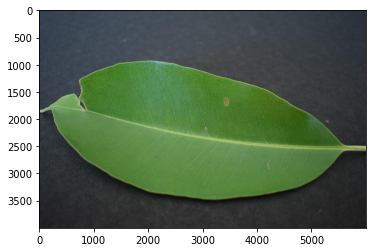

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

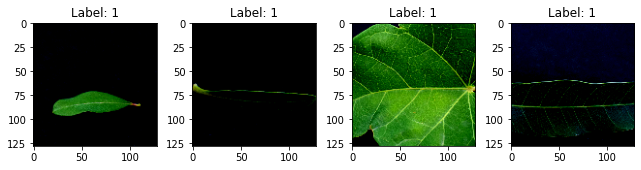

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:52] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:54] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2445559076365507 samples/sec                   batch loss = 0.07802602648735046 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.257061259836844 samples/sec                   batch loss = 0.45862627029418945 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2313077674946273 samples/sec                   batch loss = 0.792052149772644 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.261100806486772 samples/sec                   batch loss = 0.9884054660797119 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2601277416739092 samples/sec                   batch loss = 0.6482499241828918 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2682808457888772 samples/sec                   batch loss = 0.5933313965797424 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2702619581543528 samples/sec                   batch loss = 0.3355847895145416 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.265180232886088 samples/sec                   batch loss = 0.5644927024841309 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.267133479165979 samples/sec                   batch loss = 0.6184954643249512 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2704799303558478 samples/sec                   batch loss = 0.5987628102302551 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.267782389469645 samples/sec                   batch loss = 0.43756628036499023 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2658994455526884 samples/sec                   batch loss = 0.537294328212738 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2642820320157575 samples/sec                   batch loss = 0.47500288486480713 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2644200018012308 samples/sec                   batch loss = 0.9924240112304688 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.2648891145995742 samples/sec                   batch loss = 0.6438443660736084 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.264639977229688 samples/sec                   batch loss = 0.8000609278678894 | accuracy = 0.609375


Epoch[1] Batch[85] Speed: 1.2621883643484715 samples/sec                   batch loss = 0.8726492524147034 | accuracy = 0.6058823529411764


Epoch[1] Batch[90] Speed: 1.2691734101116499 samples/sec                   batch loss = 0.5973560214042664 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2621538008305266 samples/sec                   batch loss = 1.0152541399002075 | accuracy = 0.6157894736842106


Epoch[1] Batch[100] Speed: 1.2636458360479614 samples/sec                   batch loss = 0.3357492685317993 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2678982233254146 samples/sec                   batch loss = 0.33596986532211304 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.2709515294705147 samples/sec                   batch loss = 1.0477746725082397 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.2596623424597675 samples/sec                   batch loss = 0.3785032033920288 | accuracy = 0.6326086956521739


Epoch[1] Batch[120] Speed: 1.2674155782307992 samples/sec                   batch loss = 0.9394761323928833 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2637737665427038 samples/sec                   batch loss = 0.21445797383785248 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.2653596254034662 samples/sec                   batch loss = 0.6570121645927429 | accuracy = 0.6442307692307693


Epoch[1] Batch[135] Speed: 1.2618654971138499 samples/sec                   batch loss = 0.6187692284584045 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2609605273403268 samples/sec                   batch loss = 0.9741747975349426 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.265853503770538 samples/sec                   batch loss = 0.2814687490463257 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2605899803734595 samples/sec                   batch loss = 0.7549791932106018 | accuracy = 0.645


Epoch[1] Batch[155] Speed: 1.2647651533906608 samples/sec                   batch loss = 0.6580347418785095 | accuracy = 0.6435483870967742


Epoch[1] Batch[160] Speed: 1.2651580032071572 samples/sec                   batch loss = 0.8277587294578552 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.2687867946836422 samples/sec                   batch loss = 0.2442680448293686 | accuracy = 0.65


Epoch[1] Batch[170] Speed: 1.2662434940474039 samples/sec                   batch loss = 0.49144256114959717 | accuracy = 0.6544117647058824


Epoch[1] Batch[175] Speed: 1.2666384104568311 samples/sec                   batch loss = 0.6357936859130859 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2717244572348836 samples/sec                   batch loss = 0.496835321187973 | accuracy = 0.6541666666666667


Epoch[1] Batch[185] Speed: 1.263170131474313 samples/sec                   batch loss = 0.3295230269432068 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2674867211000769 samples/sec                   batch loss = 0.5959060192108154 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.2647991926256756 samples/sec                   batch loss = 1.0225417613983154 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.2654613673806472 samples/sec                   batch loss = 0.7116190195083618 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.2612225334121565 samples/sec                   batch loss = 0.9794026613235474 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.264537986037576 samples/sec                   batch loss = 0.5100619196891785 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.2638263169289379 samples/sec                   batch loss = 0.23083829879760742 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2633433416066686 samples/sec                   batch loss = 0.23380237817764282 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.2632291945020384 samples/sec                   batch loss = 0.43850138783454895 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.2669326307411275 samples/sec                   batch loss = 1.2042292356491089 | accuracy = 0.6597826086956522


Epoch[1] Batch[235] Speed: 1.2643884604729387 samples/sec                   batch loss = 0.5543936491012573 | accuracy = 0.6617021276595745


Epoch[1] Batch[240] Speed: 1.2607460932741712 samples/sec                   batch loss = 0.4198414087295532 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2671785568081742 samples/sec                   batch loss = 0.33995580673217773 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.2641210418176285 samples/sec                   batch loss = 0.40122124552726746 | accuracy = 0.668


Epoch[1] Batch[255] Speed: 1.2632611536120695 samples/sec                   batch loss = 0.5058507919311523 | accuracy = 0.6686274509803921


Epoch[1] Batch[260] Speed: 1.2638815376231378 samples/sec                   batch loss = 0.8694636225700378 | accuracy = 0.6692307692307692


Epoch[1] Batch[265] Speed: 1.2627167380556188 samples/sec                   batch loss = 0.6552395224571228 | accuracy = 0.6688679245283019


Epoch[1] Batch[270] Speed: 1.267613131901015 samples/sec                   batch loss = 1.005333662033081 | accuracy = 0.6666666666666666


Epoch[1] Batch[275] Speed: 1.2688554046062859 samples/sec                   batch loss = 0.295553982257843 | accuracy = 0.6681818181818182


Epoch[1] Batch[280] Speed: 1.264519781863536 samples/sec                   batch loss = 0.7801854014396667 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2644027539312646 samples/sec                   batch loss = 0.4862247109413147 | accuracy = 0.6631578947368421


Epoch[1] Batch[290] Speed: 1.2668061643140534 samples/sec                   batch loss = 0.5087569355964661 | accuracy = 0.6612068965517242


Epoch[1] Batch[295] Speed: 1.2667546092262976 samples/sec                   batch loss = 0.6337979435920715 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.267940288996276 samples/sec                   batch loss = 0.43620944023132324 | accuracy = 0.66


Epoch[1] Batch[305] Speed: 1.2633117588436145 samples/sec                   batch loss = 0.5780642032623291 | accuracy = 0.6622950819672131


Epoch[1] Batch[310] Speed: 1.26270400324775 samples/sec                   batch loss = 0.5322192907333374 | accuracy = 0.6588709677419354


Epoch[1] Batch[315] Speed: 1.2613301542739461 samples/sec                   batch loss = 0.5931685566902161 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.266565641672908 samples/sec                   batch loss = 0.3884202539920807 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.262322268373768 samples/sec                   batch loss = 0.36146441102027893 | accuracy = 0.6584615384615384


Epoch[1] Batch[330] Speed: 1.2664787317047248 samples/sec                   batch loss = 1.1055270433425903 | accuracy = 0.6568181818181819


Epoch[1] Batch[335] Speed: 1.2648017670961273 samples/sec                   batch loss = 0.5650719404220581 | accuracy = 0.6574626865671642


Epoch[1] Batch[340] Speed: 1.2609773971001725 samples/sec                   batch loss = 0.6465463638305664 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.2680326707884315 samples/sec                   batch loss = 0.4027419984340668 | accuracy = 0.6601449275362319


Epoch[1] Batch[350] Speed: 1.2702038705097694 samples/sec                   batch loss = 0.4433619976043701 | accuracy = 0.6607142857142857


Epoch[1] Batch[355] Speed: 1.2662083258333134 samples/sec                   batch loss = 0.42875903844833374 | accuracy = 0.6619718309859155


Epoch[1] Batch[360] Speed: 1.2668238604414066 samples/sec                   batch loss = 0.6299644708633423 | accuracy = 0.6604166666666667


Epoch[1] Batch[365] Speed: 1.2659800666357086 samples/sec                   batch loss = 0.4928256571292877 | accuracy = 0.6636986301369863


Epoch[1] Batch[370] Speed: 1.2588137965476367 samples/sec                   batch loss = 0.6879122853279114 | accuracy = 0.6628378378378378


Epoch[1] Batch[375] Speed: 1.2652945420253834 samples/sec                   batch loss = 0.5452495813369751 | accuracy = 0.664


Epoch[1] Batch[380] Speed: 1.2635879712372309 samples/sec                   batch loss = 0.9708086848258972 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.2660981511144946 samples/sec                   batch loss = 0.6128607988357544 | accuracy = 0.6675324675324675


Epoch[1] Batch[390] Speed: 1.267746944132199 samples/sec                   batch loss = 1.353620171546936 | accuracy = 0.6673076923076923


Epoch[1] Batch[395] Speed: 1.2632121693268297 samples/sec                   batch loss = 0.8634963035583496 | accuracy = 0.6651898734177215


Epoch[1] Batch[400] Speed: 1.2640826579013078 samples/sec                   batch loss = 0.4173858165740967 | accuracy = 0.66625


Epoch[1] Batch[405] Speed: 1.2652279386966985 samples/sec                   batch loss = 0.6889224648475647 | accuracy = 0.6648148148148149


Epoch[1] Batch[410] Speed: 1.265771084357347 samples/sec                   batch loss = 0.1329948902130127 | accuracy = 0.6682926829268293


Epoch[1] Batch[415] Speed: 1.2654539222909513 samples/sec                   batch loss = 0.38086217641830444 | accuracy = 0.6680722891566265


Epoch[1] Batch[420] Speed: 1.2659859894424301 samples/sec                   batch loss = 0.6973509788513184 | accuracy = 0.6666666666666666


Epoch[1] Batch[425] Speed: 1.266176121872543 samples/sec                   batch loss = 0.5549945831298828 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2663372536421917 samples/sec                   batch loss = 0.3069875240325928 | accuracy = 0.6703488372093023


Epoch[1] Batch[435] Speed: 1.2599708356216963 samples/sec                   batch loss = 0.39795738458633423 | accuracy = 0.671264367816092


Epoch[1] Batch[440] Speed: 1.2649810522950624 samples/sec                   batch loss = 0.328641414642334 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.2680901766263537 samples/sec                   batch loss = 0.9854474067687988 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.2695706368445132 samples/sec                   batch loss = 0.6340588331222534 | accuracy = 0.6722222222222223


Epoch[1] Batch[455] Speed: 1.264274029167678 samples/sec                   batch loss = 0.43327176570892334 | accuracy = 0.6736263736263737


Epoch[1] Batch[460] Speed: 1.2687479350120843 samples/sec                   batch loss = 0.45324403047561646 | accuracy = 0.6733695652173913


Epoch[1] Batch[465] Speed: 1.2694518077216512 samples/sec                   batch loss = 0.587309718132019 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.263636603971204 samples/sec                   batch loss = 0.6371241807937622 | accuracy = 0.675


Epoch[1] Batch[475] Speed: 1.2667669476315606 samples/sec                   batch loss = 0.9871370196342468 | accuracy = 0.6747368421052632


Epoch[1] Batch[480] Speed: 1.2676049910520042 samples/sec                   batch loss = 0.6969053149223328 | accuracy = 0.6739583333333333


Epoch[1] Batch[485] Speed: 1.2592516312191309 samples/sec                   batch loss = 0.2753889560699463 | accuracy = 0.6757731958762887


Epoch[1] Batch[490] Speed: 1.2657049082871785 samples/sec                   batch loss = 1.0156619548797607 | accuracy = 0.6755102040816326


Epoch[1] Batch[495] Speed: 1.2629441071057965 samples/sec                   batch loss = 0.323885053396225 | accuracy = 0.6757575757575758


Epoch[1] Batch[500] Speed: 1.265465662664552 samples/sec                   batch loss = 0.3393186032772064 | accuracy = 0.6765


Epoch[1] Batch[505] Speed: 1.2696720001991855 samples/sec                   batch loss = 0.7959242463111877 | accuracy = 0.6747524752475248


Epoch[1] Batch[510] Speed: 1.2667070751364995 samples/sec                   batch loss = 0.7385802268981934 | accuracy = 0.6720588235294118


Epoch[1] Batch[515] Speed: 1.2649449050715442 samples/sec                   batch loss = 0.40454843640327454 | accuracy = 0.6728155339805825


Epoch[1] Batch[520] Speed: 1.2678027953871827 samples/sec                   batch loss = 1.021397352218628 | accuracy = 0.6721153846153847


Epoch[1] Batch[525] Speed: 1.2679612749644849 samples/sec                   batch loss = 0.44944527745246887 | accuracy = 0.6719047619047619


Epoch[1] Batch[530] Speed: 1.2679627123849877 samples/sec                   batch loss = 0.25602808594703674 | accuracy = 0.6721698113207547


Epoch[1] Batch[535] Speed: 1.2648544030117879 samples/sec                   batch loss = 0.3956606686115265 | accuracy = 0.6710280373831776


Epoch[1] Batch[540] Speed: 1.267790436795298 samples/sec                   batch loss = 0.5711871981620789 | accuracy = 0.6731481481481482


Epoch[1] Batch[545] Speed: 1.2627320391719619 samples/sec                   batch loss = 0.33911800384521484 | accuracy = 0.6729357798165138


Epoch[1] Batch[550] Speed: 1.2658030767136803 samples/sec                   batch loss = 0.8204361796379089 | accuracy = 0.6731818181818182


Epoch[1] Batch[555] Speed: 1.2699589798765907 samples/sec                   batch loss = 0.6298456788063049 | accuracy = 0.6743243243243243


Epoch[1] Batch[560] Speed: 1.2678961153242359 samples/sec                   batch loss = 0.39697328209877014 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2650779637521412 samples/sec                   batch loss = 0.5001572966575623 | accuracy = 0.6752212389380531


Epoch[1] Batch[570] Speed: 1.2622235944974771 samples/sec                   batch loss = 0.2881627380847931 | accuracy = 0.6754385964912281


Epoch[1] Batch[575] Speed: 1.2691338547177025 samples/sec                   batch loss = 0.42745280265808105 | accuracy = 0.6765217391304348


Epoch[1] Batch[580] Speed: 1.2638611625293832 samples/sec                   batch loss = 0.4665890038013458 | accuracy = 0.6771551724137931


Epoch[1] Batch[585] Speed: 1.2687065832599433 samples/sec                   batch loss = 0.4786912202835083 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.2723940980846458 samples/sec                   batch loss = 0.645158588886261 | accuracy = 0.6766949152542373


Epoch[1] Batch[595] Speed: 1.2655069943309758 samples/sec                   batch loss = 0.3040408194065094 | accuracy = 0.676890756302521


Epoch[1] Batch[600] Speed: 1.2643161405281693 samples/sec                   batch loss = 0.4578678607940674 | accuracy = 0.6770833333333334


Epoch[1] Batch[605] Speed: 1.2653167765027735 samples/sec                   batch loss = 0.47113943099975586 | accuracy = 0.6768595041322314


Epoch[1] Batch[610] Speed: 1.2705322702105708 samples/sec                   batch loss = 0.5689039826393127 | accuracy = 0.6770491803278689


Epoch[1] Batch[615] Speed: 1.272200839685725 samples/sec                   batch loss = 0.2455293983221054 | accuracy = 0.6772357723577236


Epoch[1] Batch[620] Speed: 1.2715792990434516 samples/sec                   batch loss = 0.4075321853160858 | accuracy = 0.6782258064516129


Epoch[1] Batch[625] Speed: 1.2638632571348936 samples/sec                   batch loss = 0.5649198889732361 | accuracy = 0.6784


Epoch[1] Batch[630] Speed: 1.261526763843907 samples/sec                   batch loss = 0.9335693120956421 | accuracy = 0.6773809523809524


Epoch[1] Batch[635] Speed: 1.27249118361621 samples/sec                   batch loss = 0.47697362303733826 | accuracy = 0.6763779527559055


Epoch[1] Batch[640] Speed: 1.2663257838332653 samples/sec                   batch loss = 0.488342821598053 | accuracy = 0.6765625


Epoch[1] Batch[645] Speed: 1.2686990039967625 samples/sec                   batch loss = 0.40540963411331177 | accuracy = 0.6771317829457364


Epoch[1] Batch[650] Speed: 1.2655849877618444 samples/sec                   batch loss = 0.6902259588241577 | accuracy = 0.6776923076923077


Epoch[1] Batch[655] Speed: 1.2705187999829155 samples/sec                   batch loss = 0.5251585841178894 | accuracy = 0.6793893129770993


Epoch[1] Batch[660] Speed: 1.2642416377223085 samples/sec                   batch loss = 0.42832645773887634 | accuracy = 0.6803030303030303


Epoch[1] Batch[665] Speed: 1.2669006769302147 samples/sec                   batch loss = 0.6145115494728088 | accuracy = 0.6804511278195489


Epoch[1] Batch[670] Speed: 1.2675489656920005 samples/sec                   batch loss = 0.8146127462387085 | accuracy = 0.6798507462686567


Epoch[1] Batch[675] Speed: 1.2683181427410681 samples/sec                   batch loss = 0.7790405750274658 | accuracy = 0.6803703703703704


Epoch[1] Batch[680] Speed: 1.2647917553254646 samples/sec                   batch loss = 0.6619981527328491 | accuracy = 0.6808823529411765


Epoch[1] Batch[685] Speed: 1.2692170967250203 samples/sec                   batch loss = 0.35140663385391235 | accuracy = 0.6810218978102189


Epoch[1] Batch[690] Speed: 1.2671360631479855 samples/sec                   batch loss = 0.40350157022476196 | accuracy = 0.6811594202898551


Epoch[1] Batch[695] Speed: 1.262755039063088 samples/sec                   batch loss = 0.29681360721588135 | accuracy = 0.6820143884892086


Epoch[1] Batch[700] Speed: 1.2704173975807784 samples/sec                   batch loss = 0.4609939455986023 | accuracy = 0.6828571428571428


Epoch[1] Batch[705] Speed: 1.2673097883294335 samples/sec                   batch loss = 1.2802555561065674 | accuracy = 0.6840425531914893


Epoch[1] Batch[710] Speed: 1.268427745193634 samples/sec                   batch loss = 0.33748945593833923 | accuracy = 0.6838028169014084


Epoch[1] Batch[715] Speed: 1.275754460615723 samples/sec                   batch loss = 0.4649428427219391 | accuracy = 0.6839160839160839


Epoch[1] Batch[720] Speed: 1.2686939192253845 samples/sec                   batch loss = 0.7879502177238464 | accuracy = 0.6833333333333333


Epoch[1] Batch[725] Speed: 1.2730279304513967 samples/sec                   batch loss = 0.6071602702140808 | accuracy = 0.6844827586206896


Epoch[1] Batch[730] Speed: 1.2702645549115268 samples/sec                   batch loss = 0.5764626860618591 | accuracy = 0.6852739726027397


Epoch[1] Batch[735] Speed: 1.269229483147237 samples/sec                   batch loss = 0.5592212080955505 | accuracy = 0.685374149659864


Epoch[1] Batch[740] Speed: 1.271604164429179 samples/sec                   batch loss = 1.5809082984924316 | accuracy = 0.6847972972972973


Epoch[1] Batch[745] Speed: 1.2663611497448062 samples/sec                   batch loss = 0.27923017740249634 | accuracy = 0.6855704697986578


Epoch[1] Batch[750] Speed: 1.2685670050249789 samples/sec                   batch loss = 0.4227875769138336 | accuracy = 0.686


Epoch[1] Batch[755] Speed: 1.2642235373433954 samples/sec                   batch loss = 0.5395758748054504 | accuracy = 0.6857615894039735


Epoch[1] Batch[760] Speed: 1.2732987446591129 samples/sec                   batch loss = 0.3652726709842682 | accuracy = 0.6868421052631579


Epoch[1] Batch[765] Speed: 1.2714804253875986 samples/sec                   batch loss = 0.3282708525657654 | accuracy = 0.6875816993464052


Epoch[1] Batch[770] Speed: 1.2752243300274866 samples/sec                   batch loss = 0.44143882393836975 | accuracy = 0.6876623376623376


Epoch[1] Batch[775] Speed: 1.2639434286184388 samples/sec                   batch loss = 0.36407598853111267 | accuracy = 0.6870967741935484


Epoch[1] Batch[780] Speed: 1.2713110460329613 samples/sec                   batch loss = 0.5573346614837646 | accuracy = 0.6884615384615385


Epoch[1] Batch[785] Speed: 1.2715867200063786 samples/sec                   batch loss = 0.6180593371391296 | accuracy = 0.6888535031847134


[Epoch 1] training: accuracy=0.6894035532994924
[Epoch 1] time cost: 650.0792903900146
[Epoch 1] validation: validation accuracy=0.7044444444444444


Epoch[2] Batch[5] Speed: 1.2703035075432054 samples/sec                   batch loss = 0.5448223948478699 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.272438296221217 samples/sec                   batch loss = 0.4056127965450287 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2711309252542664 samples/sec                   batch loss = 0.6198940277099609 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2678786766742423 samples/sec                   batch loss = 0.48881995677948 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2691240622582174 samples/sec                   batch loss = 0.635924756526947 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.261244340561207 samples/sec                   batch loss = 0.5893964171409607 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2711274581892187 samples/sec                   batch loss = 0.20065844058990479 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2714037269829592 samples/sec                   batch loss = 0.8317285180091858 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.277749179778145 samples/sec                   batch loss = 0.6771193146705627 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2713166334829284 samples/sec                   batch loss = 0.2501254081726074 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2660657616743578 samples/sec                   batch loss = 0.6316996812820435 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2627474357005875 samples/sec                   batch loss = 1.1073952913284302 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.2715796845458862 samples/sec                   batch loss = 0.5455275177955627 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.2735137002865806 samples/sec                   batch loss = 0.5300769209861755 | accuracy = 0.7285714285714285


Epoch[2] Batch[75] Speed: 1.2727802117353422 samples/sec                   batch loss = 0.7388759851455688 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.2695434492378714 samples/sec                   batch loss = 0.5761892795562744 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.27435382464154 samples/sec                   batch loss = 0.2274107038974762 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.2707011533715864 samples/sec                   batch loss = 0.3979055881500244 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.267861430129583 samples/sec                   batch loss = 0.45677486062049866 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.265485230437994 samples/sec                   batch loss = 0.41304677724838257 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2764062122454296 samples/sec                   batch loss = 0.40374326705932617 | accuracy = 0.7333333333333333


Epoch[2] Batch[110] Speed: 1.2736293269399386 samples/sec                   batch loss = 0.2685934901237488 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.2666261701815713 samples/sec                   batch loss = 0.33874794840812683 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.2685421623598134 samples/sec                   batch loss = 0.4547206163406372 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2749121984584986 samples/sec                   batch loss = 0.567236065864563 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2667041103517092 samples/sec                   batch loss = 0.17356082797050476 | accuracy = 0.7461538461538462


Epoch[2] Batch[135] Speed: 1.2691575684564278 samples/sec                   batch loss = 0.17533789575099945 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.2691538241229774 samples/sec                   batch loss = 0.8768839836120605 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2685486846641947 samples/sec                   batch loss = 0.5987650752067566 | accuracy = 0.753448275862069


Epoch[2] Batch[150] Speed: 1.264862794649602 samples/sec                   batch loss = 0.8626267313957214 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2723216313657637 samples/sec                   batch loss = 1.0223749876022339 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2634482800169593 samples/sec                   batch loss = 0.3404586613178253 | accuracy = 0.74375


Epoch[2] Batch[165] Speed: 1.267201144688534 samples/sec                   batch loss = 0.4777906835079193 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2731319720854024 samples/sec                   batch loss = 0.22110338509082794 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2689268051871867 samples/sec                   batch loss = 0.3789404034614563 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2671186453991052 samples/sec                   batch loss = 0.911165714263916 | accuracy = 0.7472222222222222


Epoch[2] Batch[185] Speed: 1.2680971735258701 samples/sec                   batch loss = 0.5230860114097595 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2723780794308022 samples/sec                   batch loss = 0.344563364982605 | accuracy = 0.7447368421052631


Epoch[2] Batch[195] Speed: 1.2654368370957916 samples/sec                   batch loss = 0.3701895773410797 | accuracy = 0.7448717948717949


Epoch[2] Batch[200] Speed: 1.2724465957770517 samples/sec                   batch loss = 0.41535699367523193 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.2729475682401357 samples/sec                   batch loss = 0.3331797420978546 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.274958412588162 samples/sec                   batch loss = 0.4034464955329895 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2756054714155753 samples/sec                   batch loss = 0.5252800583839417 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.273473680567089 samples/sec                   batch loss = 1.503990888595581 | accuracy = 0.7511363636363636


Epoch[2] Batch[225] Speed: 1.272808600333686 samples/sec                   batch loss = 0.21442903578281403 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2715464358202078 samples/sec                   batch loss = 0.9612495303153992 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.2754980190387886 samples/sec                   batch loss = 0.6091985702514648 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2719194994568048 samples/sec                   batch loss = 0.4705118238925934 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2736170478624695 samples/sec                   batch loss = 1.1721727848052979 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2743334976772216 samples/sec                   batch loss = 0.6723940372467041 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.2724048095782021 samples/sec                   batch loss = 0.23093874752521515 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.2721433462724754 samples/sec                   batch loss = 0.25153496861457825 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2692665478391654 samples/sec                   batch loss = 1.5232291221618652 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2711581808965804 samples/sec                   batch loss = 0.3932532072067261 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.27207717740043 samples/sec                   batch loss = 0.24223953485488892 | accuracy = 0.7472727272727273


Epoch[2] Batch[280] Speed: 1.2698529572047579 samples/sec                   batch loss = 0.9868038892745972 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2728280095940727 samples/sec                   batch loss = 0.6613257527351379 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.2790321776475595 samples/sec                   batch loss = 0.4449954628944397 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2750293389008214 samples/sec                   batch loss = 0.47413671016693115 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.2821348045329382 samples/sec                   batch loss = 0.6528725624084473 | accuracy = 0.745


Epoch[2] Batch[305] Speed: 1.2714891942619797 samples/sec                   batch loss = 0.2538765072822571 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.2775213131321514 samples/sec                   batch loss = 0.36987417936325073 | accuracy = 0.7475806451612903


Epoch[2] Batch[315] Speed: 1.2720434204236273 samples/sec                   batch loss = 0.19848887622356415 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.2778092247848993 samples/sec                   batch loss = 0.5815852284431458 | accuracy = 0.74765625


Epoch[2] Batch[325] Speed: 1.2724479468777834 samples/sec                   batch loss = 1.0095715522766113 | accuracy = 0.7476923076923077


Epoch[2] Batch[330] Speed: 1.2758405138520867 samples/sec                   batch loss = 0.7347169518470764 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2758009298618895 samples/sec                   batch loss = 0.16009066998958588 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2729976968424266 samples/sec                   batch loss = 0.6627476811408997 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.274266907212431 samples/sec                   batch loss = 0.25156229734420776 | accuracy = 0.7478260869565218


Epoch[2] Batch[350] Speed: 1.2743512111383712 samples/sec                   batch loss = 0.4216970205307007 | accuracy = 0.7478571428571429


Epoch[2] Batch[355] Speed: 1.2752170604014286 samples/sec                   batch loss = 0.7490769028663635 | accuracy = 0.747887323943662


Epoch[2] Batch[360] Speed: 1.2729342399120482 samples/sec                   batch loss = 0.5096791386604309 | accuracy = 0.7472222222222222


Epoch[2] Batch[365] Speed: 1.270684503635079 samples/sec                   batch loss = 0.4190549850463867 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.2727060597385074 samples/sec                   batch loss = 0.45557674765586853 | accuracy = 0.7472972972972973


Epoch[2] Batch[375] Speed: 1.2670746246518176 samples/sec                   batch loss = 1.0234678983688354 | accuracy = 0.7453333333333333


Epoch[2] Batch[380] Speed: 1.2775520538457994 samples/sec                   batch loss = 0.5544054508209229 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.27092697843179 samples/sec                   batch loss = 0.597557544708252 | accuracy = 0.7448051948051948


Epoch[2] Batch[390] Speed: 1.2684432809321868 samples/sec                   batch loss = 0.3684687912464142 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.271471174838033 samples/sec                   batch loss = 0.41442063450813293 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.2674911259009614 samples/sec                   batch loss = 0.38206613063812256 | accuracy = 0.74625


Epoch[2] Batch[405] Speed: 1.269191076423882 samples/sec                   batch loss = 0.5282921195030212 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.26531820793367 samples/sec                   batch loss = 0.6151337623596191 | accuracy = 0.7439024390243902


Epoch[2] Batch[415] Speed: 1.2718842080971973 samples/sec                   batch loss = 0.3115847408771515 | accuracy = 0.744578313253012


Epoch[2] Batch[420] Speed: 1.2651323398712366 samples/sec                   batch loss = 0.3275105953216553 | accuracy = 0.7458333333333333


Epoch[2] Batch[425] Speed: 1.2662163531883797 samples/sec                   batch loss = 0.7088756561279297 | accuracy = 0.7452941176470588


Epoch[2] Batch[430] Speed: 1.2728010685413176 samples/sec                   batch loss = 0.4787783622741699 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.273051693337276 samples/sec                   batch loss = 0.5025611519813538 | accuracy = 0.7425287356321839


Epoch[2] Batch[440] Speed: 1.2683705922950559 samples/sec                   batch loss = 0.31398171186447144 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.267844758915739 samples/sec                   batch loss = 0.25673964619636536 | accuracy = 0.7432584269662922


Epoch[2] Batch[450] Speed: 1.265967934607867 samples/sec                   batch loss = 0.15266898274421692 | accuracy = 0.745


Epoch[2] Batch[455] Speed: 1.2731127467700787 samples/sec                   batch loss = 0.7485565543174744 | accuracy = 0.7450549450549451


Epoch[2] Batch[460] Speed: 1.2751259547835836 samples/sec                   batch loss = 0.25853362679481506 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.2726505479487698 samples/sec                   batch loss = 0.4316033124923706 | accuracy = 0.7473118279569892


Epoch[2] Batch[470] Speed: 1.2703237061446018 samples/sec                   batch loss = 0.22522121667861938 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.271725806802497 samples/sec                   batch loss = 0.6914633512496948 | accuracy = 0.7457894736842106


Epoch[2] Batch[480] Speed: 1.2698833299777015 samples/sec                   batch loss = 0.4353228211402893 | accuracy = 0.7458333333333333


Epoch[2] Batch[485] Speed: 1.2762101799899483 samples/sec                   batch loss = 0.4130607843399048 | accuracy = 0.7463917525773196


Epoch[2] Batch[490] Speed: 1.2724864544548322 samples/sec                   batch loss = 0.16122610867023468 | accuracy = 0.7484693877551021


Epoch[2] Batch[495] Speed: 1.2722475327914036 samples/sec                   batch loss = 0.5102038383483887 | accuracy = 0.7484848484848485


Epoch[2] Batch[500] Speed: 1.2702650357936498 samples/sec                   batch loss = 0.6073682904243469 | accuracy = 0.747


Epoch[2] Batch[505] Speed: 1.2761413548146048 samples/sec                   batch loss = 1.3133928775787354 | accuracy = 0.7455445544554455


Epoch[2] Batch[510] Speed: 1.274522950765623 samples/sec                   batch loss = 0.3016691207885742 | accuracy = 0.7465686274509804


Epoch[2] Batch[515] Speed: 1.2708169436643808 samples/sec                   batch loss = 0.5208171606063843 | accuracy = 0.746116504854369


Epoch[2] Batch[520] Speed: 1.2715063469153958 samples/sec                   batch loss = 0.6049923896789551 | accuracy = 0.7456730769230769


Epoch[2] Batch[525] Speed: 1.2712952473022738 samples/sec                   batch loss = 0.317294180393219 | accuracy = 0.7466666666666667


Epoch[2] Batch[530] Speed: 1.2701018453069632 samples/sec                   batch loss = 0.4857174754142761 | accuracy = 0.7476415094339622


Epoch[2] Batch[535] Speed: 1.2769222619552847 samples/sec                   batch loss = 0.5377383232116699 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.2714480490529967 samples/sec                   batch loss = 0.6692163348197937 | accuracy = 0.7481481481481481


Epoch[2] Batch[545] Speed: 1.2631871555163872 samples/sec                   batch loss = 1.050572156906128 | accuracy = 0.7486238532110092


Epoch[2] Batch[550] Speed: 1.2694448919177346 samples/sec                   batch loss = 0.39923837780952454 | accuracy = 0.7495454545454545


Epoch[2] Batch[555] Speed: 1.2669202891081373 samples/sec                   batch loss = 0.1400931477546692 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.2687212623436324 samples/sec                   batch loss = 0.5051575899124146 | accuracy = 0.75


Epoch[2] Batch[565] Speed: 1.2651863390290745 samples/sec                   batch loss = 0.6341879367828369 | accuracy = 0.7477876106194691


Epoch[2] Batch[570] Speed: 1.270852175820593 samples/sec                   batch loss = 0.729500412940979 | accuracy = 0.7482456140350877


Epoch[2] Batch[575] Speed: 1.270889046534908 samples/sec                   batch loss = 0.3094364106655121 | accuracy = 0.7495652173913043


Epoch[2] Batch[580] Speed: 1.2714254058702616 samples/sec                   batch loss = 0.39228832721710205 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.2647230121142576 samples/sec                   batch loss = 0.2553671598434448 | accuracy = 0.7478632478632479


Epoch[2] Batch[590] Speed: 1.273857741602381 samples/sec                   batch loss = 0.22274205088615417 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.2672460357055588 samples/sec                   batch loss = 0.5806726813316345 | accuracy = 0.7474789915966387


Epoch[2] Batch[600] Speed: 1.2600529745677163 samples/sec                   batch loss = 0.3737885057926178 | accuracy = 0.7475


Epoch[2] Batch[605] Speed: 1.267780186053056 samples/sec                   batch loss = 0.3094812333583832 | accuracy = 0.7479338842975206


Epoch[2] Batch[610] Speed: 1.2656694835377575 samples/sec                   batch loss = 0.24038687348365784 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.272843556742054 samples/sec                   batch loss = 0.18460094928741455 | accuracy = 0.75


Epoch[2] Batch[620] Speed: 1.2727692042522096 samples/sec                   batch loss = 0.43342357873916626 | accuracy = 0.75


Epoch[2] Batch[625] Speed: 1.2756922805528816 samples/sec                   batch loss = 0.6647045016288757 | accuracy = 0.7504


Epoch[2] Batch[630] Speed: 1.2664067460106285 samples/sec                   batch loss = 1.1378206014633179 | accuracy = 0.75


Epoch[2] Batch[635] Speed: 1.2690571511626016 samples/sec                   batch loss = 0.28199806809425354 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.2659732841347904 samples/sec                   batch loss = 0.3006761074066162 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.262739167147799 samples/sec                   batch loss = 0.5420932769775391 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2652797512822511 samples/sec                   batch loss = 0.6367573142051697 | accuracy = 0.7523076923076923


Epoch[2] Batch[655] Speed: 1.2699280267319548 samples/sec                   batch loss = 0.4648624062538147 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.265838699956556 samples/sec                   batch loss = 0.706001341342926 | accuracy = 0.753030303030303


Epoch[2] Batch[665] Speed: 1.2668175471716776 samples/sec                   batch loss = 0.34343013167381287 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.273306475617751 samples/sec                   batch loss = 0.386940598487854 | accuracy = 0.7514925373134328


Epoch[2] Batch[675] Speed: 1.2744697975360972 samples/sec                   batch loss = 0.5946436524391174 | accuracy = 0.7518518518518519


Epoch[2] Batch[680] Speed: 1.2723755705215527 samples/sec                   batch loss = 0.18416354060173035 | accuracy = 0.7522058823529412


Epoch[2] Batch[685] Speed: 1.2772384901753937 samples/sec                   batch loss = 0.32310712337493896 | accuracy = 0.7525547445255475


Epoch[2] Batch[690] Speed: 1.2788830068464372 samples/sec                   batch loss = 0.2835189700126648 | accuracy = 0.7543478260869565


Epoch[2] Batch[695] Speed: 1.2737909107149894 samples/sec                   batch loss = 0.46812254190444946 | accuracy = 0.7546762589928058


Epoch[2] Batch[700] Speed: 1.2779362429462857 samples/sec                   batch loss = 0.23683926463127136 | accuracy = 0.7553571428571428


Epoch[2] Batch[705] Speed: 1.2742067107761168 samples/sec                   batch loss = 0.43022793531417847 | accuracy = 0.7567375886524823


Epoch[2] Batch[710] Speed: 1.2754850251227858 samples/sec                   batch loss = 0.6370262503623962 | accuracy = 0.7556338028169014


Epoch[2] Batch[715] Speed: 1.2739852329873866 samples/sec                   batch loss = 0.6893877387046814 | accuracy = 0.7548951048951049


Epoch[2] Batch[720] Speed: 1.2765894825812114 samples/sec                   batch loss = 0.4419971704483032 | accuracy = 0.7555555555555555


Epoch[2] Batch[725] Speed: 1.2737602540290303 samples/sec                   batch loss = 0.4493533670902252 | accuracy = 0.7551724137931034


Epoch[2] Batch[730] Speed: 1.2704061423349957 samples/sec                   batch loss = 1.540977954864502 | accuracy = 0.7554794520547945


Epoch[2] Batch[735] Speed: 1.2726737174982912 samples/sec                   batch loss = 0.42276307940483093 | accuracy = 0.7557823129251701


Epoch[2] Batch[740] Speed: 1.2775093480011885 samples/sec                   batch loss = 0.34962713718414307 | accuracy = 0.7557432432432433


Epoch[2] Batch[745] Speed: 1.2695802440510902 samples/sec                   batch loss = 0.47882920503616333 | accuracy = 0.7563758389261745


Epoch[2] Batch[750] Speed: 1.2763915490075322 samples/sec                   batch loss = 0.30334141850471497 | accuracy = 0.757


Epoch[2] Batch[755] Speed: 1.2697733797409838 samples/sec                   batch loss = 0.5462321639060974 | accuracy = 0.7552980132450331


Epoch[2] Batch[760] Speed: 1.277442133423485 samples/sec                   batch loss = 0.35325655341148376 | accuracy = 0.75625


Epoch[2] Batch[765] Speed: 1.274770379784288 samples/sec                   batch loss = 0.8672235012054443 | accuracy = 0.7571895424836601


Epoch[2] Batch[770] Speed: 1.2738846306814773 samples/sec                   batch loss = 0.4298451542854309 | accuracy = 0.7568181818181818


Epoch[2] Batch[775] Speed: 1.2723415082327254 samples/sec                   batch loss = 0.07027297466993332 | accuracy = 0.7577419354838709


Epoch[2] Batch[780] Speed: 1.264225061565845 samples/sec                   batch loss = 0.03149862214922905 | accuracy = 0.7586538461538461


Epoch[2] Batch[785] Speed: 1.2654602219765303 samples/sec                   batch loss = 1.1146409511566162 | accuracy = 0.7579617834394905


[Epoch 2] training: accuracy=0.758248730964467
[Epoch 2] time cost: 638.0448954105377
[Epoch 2] validation: validation accuracy=0.7877777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)